In [17]:
from custom_losses import dice,IoULoss
from BIP_methods import *
from eval_tools import *
from data_tools import *
from seq_net import *
from unet import UNet


import cv2
import json
import math
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [18]:
'''os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = torch.device("cuda:0")'''

'os.environ["CUDA_VISIBLE_DEVICES"] = "0" \ntorch.set_default_tensor_type(\'torch.cuda.FloatTensor\')\ndevice = torch.device("cuda:0")'

In [19]:
device = torch.device("cpu")

In [20]:
test_json = json.load(open('test.json'))
folder = '/mnt/LAIN_EXTERNAL2/waterpolo_anyagok/vizilabda_meccsek/frames'
criterion = IoULoss()

# Evaluation of kmeans method

In [21]:
test_ds = dataset_with_mask(folder,test_json)
test_iterator = data.DataLoader(test_ds, 
                                batch_size = 8)
counter = 0
'''avg_tp_pixels = 0
avg_tn_pixels = 0
avg_fp_pixels = 0
avg_fn_pixels = 0
avg_f1 = 0
avg_acc = 0
avg_positive_pixels = 0
avg_negative_pixels = 0'''
avg_IoU = 0

for i, d in enumerate(test_iterator, 0):
    inputs, labels,fnames = d[0].cpu(), d[1].cpu(),d[2]
    for j in range(len(inputs)):
        inp = np.transpose(inputs[j][:][:][:],(1,2,0)).detach().numpy()
        output_kmean = kmean_process((inp*255).astype(np.uint8))
        mask = kmean_to_mask(output_kmean).astype(np.float)/255
        mask = circularity(mask,th = 0.05)
        mask =  transforms.functional.to_tensor(mask)
        IoU = criterion(labels[j][:][:][:],mask)
        if not math.isnan(IoU.item()):
            avg_IoU += IoU.item()
            counter += 1
        '''f1_loc = f1(labels[j][:][:][:],mask)
        tp_loc = tp_pixels(labels[j][0][:][:],mask).item()
        tn_loc = tn_pixels(labels[j][0][:][:],mask).item()
        fp_loc = fp_pixels(labels[j][0][:][:],mask).item()
        fn_loc = fn_pixels(labels[j][0][:][:],mask).item()
        acc_loc = (tp_loc + tn_loc)/(tp_loc + tn_loc + fp_loc + fn_loc)
        if not math.isnan(f1_loc) and not math.isnan(acc_loc): 
            avg_acc += acc_loc
            avg_f1 += f1_loc
            avg_tp_pixels += tp_loc
            avg_fp_pixels += fp_loc
            avg_tn_pixels += tn_loc
            avg_fn_pixels += fn_loc
            counter += 1 
            avg_positive_pixels += torch.count_nonzero(labels[j][0][:][:])
            avg_negative_pixels += (129600 - torch.count_nonzero(labels[j][0][:][:]))'''
        
        
    if i%10 == 0:
        print("Checkpoint",i)
        
        
'''avg_acc = avg_acc/counter        
avg_f1 = avg_f1/counter
avg_tp_pixels = avg_tp_pixels/counter
avg_fp_pixels = avg_fp_pixels/counter
avg_tn_pixels = avg_tn_pixels/counter
avg_fn_pixels = avg_fn_pixels/counter
avg_positive_pixels =avg_positive_pixels/counter
avg_negative_pixels = avg_negative_pixels/counter
print(avg_tp_pixels,avg_fp_pixels,avg_tn_pixels,avg_fn_pixels)
print(avg_acc,avg_f1)'''
avg_IoU = avg_IoU/counter
print(avg_IoU)

/home/csenge/.local/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Checkpoint 0
Checkpoint 10
Checkpoint 20
Checkpoint 30
Checkpoint 40
Checkpoint 50
Checkpoint 60
Checkpoint 70
Checkpoint 80
Checkpoint 90
Checkpoint 100
Checkpoint 110
Checkpoint 120
Checkpoint 130
Checkpoint 140
0.40934244290689664


In [11]:
print(avg_positive_pixels,avg_negative_pixels)

tensor(140.1377, device='cpu') tensor(129459.8516, device='cpu')


/opt/conda/envs/lain_new/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  
/opt/conda/envs/lain_new/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  if sys.path[0] == '':


0.9921488009696754 0.0015488002695039846


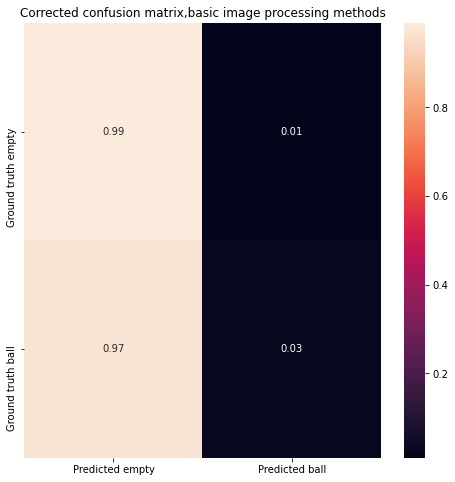

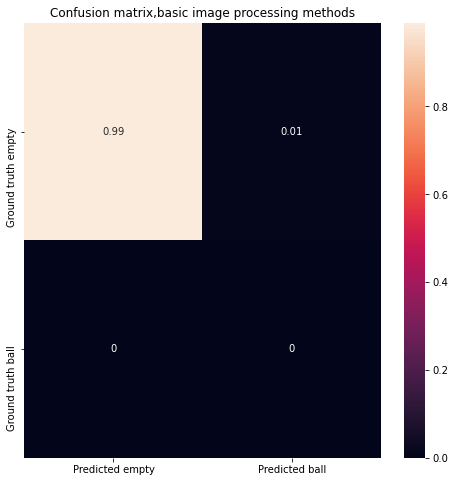

In [7]:
anp = avg_tp_pixels+avg_fp_pixels+avg_tn_pixels+avg_fn_pixels
CM = [[round(avg_tn_pixels/avg_negative_pixels.item(),2),round(avg_fp_pixels/avg_negative_pixels.item(),2)],[round(avg_fn_pixels/avg_positive_pixels.item(),2),round(avg_tp_pixels/avg_positive_pixels.item(),2)]]
X_labels = ['Predicted empty', 'Predicted ball']
Y_labels = ['Ground truth empty', 'Ground truth ball']
plt.figure(figsize = (8,8))
sns.heatmap(CM,xticklabels=X_labels, yticklabels=Y_labels,annot=True).set(Title = 'Corrected confusion matrix,basic image processing methods')

CM = [[round(avg_tn_pixels/anp,2),round(avg_fp_pixels/anp,2)],[round(avg_fn_pixels/anp,2),round(avg_tp_pixels/anp,2)]]
X_labels = ['Predicted empty', 'Predicted ball']
Y_labels = ['Ground truth empty', 'Ground truth ball']
plt.figure(figsize = (8,8))
sns.heatmap(CM,xticklabels=X_labels, yticklabels=Y_labels,annot=True).set(Title = 'Confusion matrix,basic image processing methods')
print(avg_acc,avg_f1)

# Evaluation of the sequential network

In [ ]:
test_ds = dataset_with_corners(folder,test_json)
test_iterator = data.DataLoader(test_ds, 
                                batch_size = 8)

#criterion = nn.SmoothL1Loss().to(device)
criterion = IoULoss()
model = seq_model.to('cpu')
optimizer = optim.Adagrad(model.parameters(),lr=0.0005)

model.load_state_dict(torch.load('top_results/flattened_model_net_epoch58_loss=0.013814487727100925.pt'))
model.to('cpu')
model.eval()

In [22]:
'''counter = 0
avg_tp_pixels = 0
avg_tn_pixels = 0
avg_fp_pixels = 0
avg_fn_pixels = 0
avg_f1 = 0
avg_acc = 0
avg_positive_pixels = 0
avg_negative_pixels = 0'''
avg_IoU = 0

for i, d in enumerate(test_iterator, 0):
    inputs, labels,fnames = d[0].cpu(), d[1].cpu(),d[2]
    outputs = model(inputs)
    outputs = Bbox_to_arr(outputs).cpu()
    labels = Bbox_to_arr(labels).cpu()
    #print(np.amin(outputs.cpu().detach().numpy()),np.amin(labels.cpu().detach().numpy()))
    for j in range(len(inputs)):
        IoU = criterion(labels[j][:][:][:],outputs[j][:][:][:])
        if not math.isnan(IoU.item()):
            avg_IoU += IoU.item()
            counter += 1
        
        '''f1_loc = f1(labels[j][:][:][:],outputs[j][0][:][:])
        tp_loc = tp_pixels(labels[j][0][:][:],outputs[j][0][:][:]).item()
        tn_loc = tn_pixels(labels[j][0][:][:],outputs[j][0][:][:]).item()
        fp_loc = fp_pixels(labels[j][0][:][:],outputs[j][0][:][:]).item()
        fn_loc = fn_pixels(labels[j][0][:][:],outputs[j][0][:][:]).item()
        acc_loc = (tp_loc + tn_loc)/(tp_loc + tn_loc + fp_loc + fn_loc)
        
        if not math.isnan(f1_loc) and not math.isnan(acc_loc): 
            avg_acc += acc_loc
            avg_f1 += f1_loc
            avg_tp_pixels += tp_loc
            avg_fp_pixels += fp_loc
            avg_tn_pixels += tn_loc
            avg_fn_pixels += fn_loc
            avg_positive_pixels += torch.count_nonzero(labels[j][0][:][:])
            avg_negative_pixels += (129600 - torch.count_nonzero(labels[j][0][:][:]))
            counter += 1 '''
        
        
    if i%10 == 0:
        print("Checkpoint",i)
        
        
'''avg_acc = avg_acc/counter           
avg_f1 = avg_f1/counter
avg_tp_pixels = avg_tp_pixels/counter
avg_fp_pixels = avg_fp_pixels/counter
avg_tn_pixels = avg_tn_pixels/counter
avg_fn_pixels = avg_fn_pixels/counter
avg_positive_pixels =avg_positive_pixels/counter
avg_negative_pixels = avg_negative_pixels/counter
print(avg_tp_pixels,avg_fp_pixels,avg_tn_pixels,avg_fn_pixels)
print(avg_acc,avg_f1)'''
avg_IoU = avg_IoU/counter
print(avg_IoU)

IndexError: index 1 is out of bounds for dimension 0 with size 1

0.9977689434603679 1.871420501450561e-05


/opt/conda/envs/lain_new/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  
/opt/conda/envs/lain_new/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  if sys.path[0] == '':


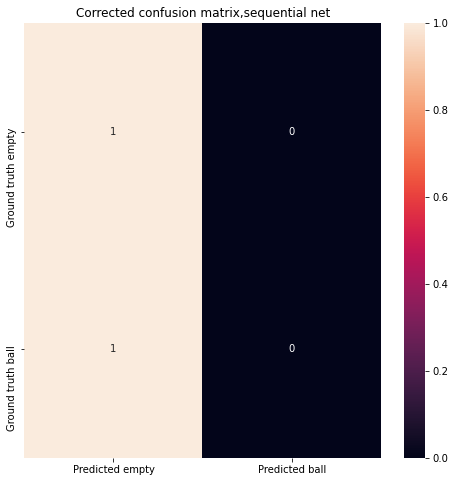

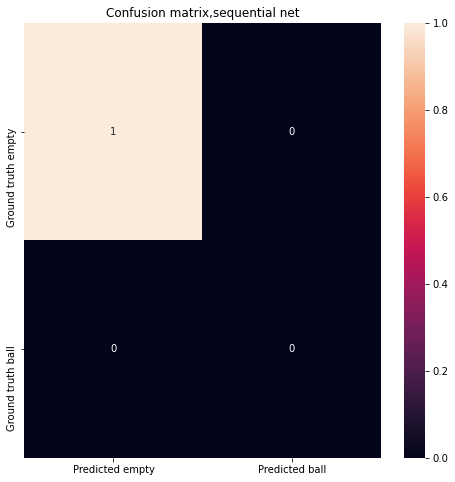

In [12]:
anp = avg_tp_pixels+avg_fp_pixels+avg_tn_pixels+avg_fn_pixels
CM = [[round(avg_tn_pixels/avg_negative_pixels.item(),2),round(avg_fp_pixels/avg_negative_pixels.item(),2)],[round(avg_fn_pixels/avg_positive_pixels.item(),2),round(avg_tp_pixels/avg_positive_pixels.item(),2)]]
X_labels = ['Predicted empty', 'Predicted ball']
Y_labels = ['Ground truth empty', 'Ground truth ball']
plt.figure(figsize = (8,8))
sns.heatmap(CM,xticklabels=X_labels, yticklabels=Y_labels,annot=True).set(Title = 'Corrected confusion matrix,sequential net')

CM = [[round(avg_tn_pixels/anp,2),round(avg_fp_pixels/anp,2)],[round(avg_fn_pixels/anp,2),round(avg_tp_pixels/anp,2)]]
X_labels = ['Predicted empty', 'Predicted ball']
Y_labels = ['Ground truth empty', 'Ground truth ball']
plt.figure(figsize = (8,8))
sns.heatmap(CM,xticklabels=X_labels, yticklabels=Y_labels,annot=True).set(Title = 'Confusion matrix,sequential net')
print(avg_acc,avg_f1)

# Evaluation of the U-net

In [13]:
test_ds = dataset_with_mask(folder,test_json)
test_iterator = data.DataLoader(test_ds, 
                                batch_size = 8)

model = UNet(in_channels=3,
             out_channels=1,
             n_blocks=2,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2)
model.load_state_dict(torch.load('top_results/otf_model_net_epoch41_loss=0.4606550086411276.pt'))
model.to('cpu')
model.eval()

{'UNet': {'in_channels': 3, 'out_channels': 1, 'n_blocks': 2, 'start_filters': 32, 'activation': 'relu', 'normalization': 'batch', 'conv_mode': 'same', 'dim': 2, 'up_mode': 'transposed'}}

In [14]:
'''counter = 0
avg_tp_pixels = 0
avg_tn_pixels = 0
avg_fp_pixels = 0
avg_fn_pixels = 0
avg_f1 = 0
avg_acc = 0'''
avg_IoU = 0


for i, d in enumerate(test_iterator, 0):
    inputs, labels,fnames = d[0].cpu(), d[1].cpu(),d[2]
    outputs = model(inputs)
    outputs[outputs<0.15] = 0
    outputs[outputs>0.15] = 1
    #evaluation(labels,outputs,0.5)
    for j in range(len(inputs)):
        IoU = criterion(labels[j][:][:][:],outputs[j][:][:][:])
        if not math.isnan(IoU.item()):
            avg_IoU += IoU.item()
            counter += 1
        
        '''f1_loc = f1(labels[j][:][:][:],outputs[j][0][:][:])
        tp_loc = tp_pixels(labels[j][0][:][:],outputs[j][0][:][:]).item()
        tn_loc = tn_pixels(labels[j][0][:][:],outputs[j][0][:][:]).item()
        fp_loc = fp_pixels(labels[j][0][:][:],outputs[j][0][:][:]).item()
        fn_loc = fn_pixels(labels[j][0][:][:],outputs[j][0][:][:]).item()
        acc_loc = (tp_loc + tn_loc)/(tp_loc + tn_loc + fp_loc + fn_loc)
        if not math.isnan(f1_loc) and not math.isnan(acc_loc):  
            avg_acc += acc_loc
            avg_f1 += f1_loc
            avg_tp_pixels += tp_loc
            avg_fp_pixels += fp_loc
            avg_tn_pixels += tn_loc
            avg_fn_pixels += fn_loc
            counter += 1  
            avg_positive_pixels += torch.count_nonzero(labels[j][0][:][:])
            avg_negative_pixels += (129600 - torch.count_nonzero(labels[j][0][:][:]))'''
        
        
    if i%10 == 0:
        print("Checkpoint",i)
        
        
'''avg_acc = avg_acc/counter           
avg_f1 = avg_f1/counter
avg_tp_pixels = avg_tp_pixels/counter
avg_fp_pixels = avg_fp_pixels/counter
avg_tn_pixels = avg_tn_pixels/counter
avg_fn_pixels = avg_fn_pixels/counter
avg_positive_pixels =(avg_positive_pixels/counter).item()
avg_negative_pixels = (avg_negative_pixels/counter).item()
print(avg_tp_pixels,avg_fp_pixels,avg_tn_pixels,avg_fn_pixels)
print(avg_positive_pixels,avg_negative_pixels)'''
avg_IoU = avg_IoU/counter
print(avg_IoU)

Checkpoint 0
Checkpoint 10
Checkpoint 20
Checkpoint 30
Checkpoint 40
Checkpoint 50
Checkpoint 60
Checkpoint 70
Checkpoint 80
Checkpoint 90
Checkpoint 100
Checkpoint 110
Checkpoint 120
Checkpoint 130
Checkpoint 140
92.72300469483568 35.667605633802815 129420.23849765258 51.370892018779344
144.22547912597656 129577.4609375


0.999328406653916 0.0005350157419187115


/opt/conda/envs/lain_new/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  
/opt/conda/envs/lain_new/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  if sys.path[0] == '':


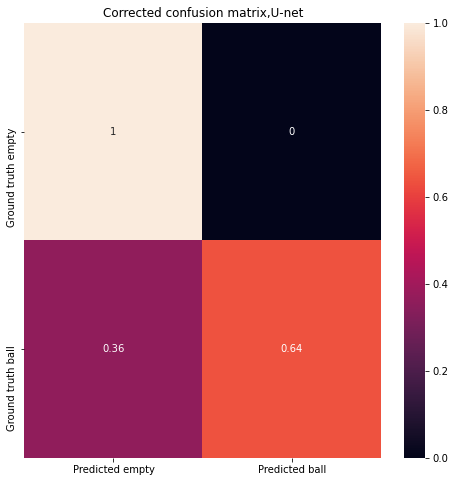

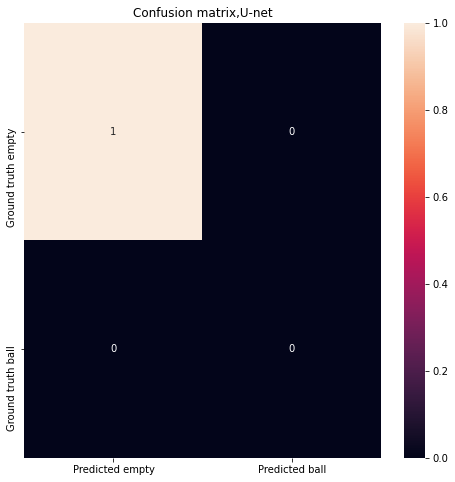

In [16]:
anp = avg_tp_pixels+avg_fp_pixels+avg_tn_pixels+avg_fn_pixels
CM = [[round(avg_tn_pixels/avg_negative_pixels,2),round(avg_fp_pixels/avg_negative_pixels,2)],[round(avg_fn_pixels/avg_positive_pixels,2),round(avg_tp_pixels/avg_positive_pixels,2)]]
X_labels = ['Predicted empty', 'Predicted ball']
Y_labels = ['Ground truth empty', 'Ground truth ball']
plt.figure(figsize = (8,8))
sns.heatmap(CM,xticklabels=X_labels, yticklabels=Y_labels,annot=True).set(Title = 'Corrected confusion matrix,U-net')

CM = [[round(avg_tn_pixels/anp,2),round(avg_fp_pixels/anp,2)],[round(avg_fn_pixels/anp,2),round(avg_tp_pixels/anp,2)]]
X_labels = ['Predicted empty', 'Predicted ball']
Y_labels = ['Ground truth empty', 'Ground truth ball']
plt.figure(figsize = (8,8))
sns.heatmap(CM,xticklabels=X_labels, yticklabels=Y_labels,annot=True).set(Title = 'Confusion matrix,U-net')
print(avg_acc,avg_f1)